In [19]:
import joblib
import selfies
from rdkit import Chem
from tqdm.auto import tqdm

In [20]:
example_dataset = joblib.load("data/prepared/ogbg-molhiv.joblib")
example_dataset.data

,HIV_active,smiles,graph
0,0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
1,0,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
2,0,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,"{'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4, 5,..."
3,0,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4,0,O=S(=O)(O)CCS(=O)(=O)O,"{'edge_index': [[0, 1, 1, 2, 1, 3, 1, 4, 4, 5,..."
...,...,...,...
41122,0,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
41123,0,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
41124,0,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
41125,0,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."


In [21]:
import selfies as sf
import logging as log


def smiles_to_selfies(smiles):
    default_constaints = sf.get_semantic_constraints()
    default_constaints['P-1'] = 6 # molhiv
    default_constaints['Fe'] = 10 # molhiv
    default_constaints['Fe+3'] = 10 # molhiv
    default_constaints['Fe+2'] = 9 # molhiv
    # default_constaints['IH1'] = 2 # moltoxcast -- can't do that lol
    sf.set_semantic_constraints(default_constaints)
    try:
        return sf.encoder(Chem.CanonSmiles(smiles))
    except Exception as e:
        try:
            log.error(f"Error encoding SMILES {smiles}: {e}")
            return sf.encoder(smiles)
        except Exception as e2:
            log.error(f"Error encoding SMILES {smiles} with fallback: {e2}")
            return None

def check_if_selfies_valid(smiles):
    try:
        rs = smiles_to_selfies(smiles)
        return rs is not None
    except Exception as e:
        log.error(f"Invalid SELFIES {smiles}: {e}")
        return False

In [22]:
example_smiles = example_dataset.data.smiles.tolist()
check_if_selfies_valid(example_smiles[0])

True

In [23]:
from rdkit.Chem import MolFromSmiles

def has_dative_bond(smiles):
    mol = MolFromSmiles(smiles)
    if mol is None:
        return False
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DATIVE:
            return True
    return False

# Example usage:
has_dative_bond(example_smiles[0])

False

In [24]:
def validate_selfies_in_dataset(dataset):
    valid_selfies = []
    dative_bond = []
    selfies_fails = []
    for smiles in tqdm(dataset.data.smiles.tolist(), desc="Validating SELFIES", leave=False):
        selfies_success = check_if_selfies_valid(smiles)
        dative_bond_success = not has_dative_bond(smiles)
        
        if selfies_success and dative_bond_success:
            valid_selfies.append(smiles)
        else:
            if not selfies_success:
                selfies_fails.append(smiles)
            if not dative_bond_success:
                dative_bond.append(smiles)
    return valid_selfies, dative_bond, selfies_fails

In [25]:
val, dat, sel = validate_selfies_in_dataset(example_dataset)

Validating SELFIES:   0%|          | 0/41127 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
len(val), len(dat), len(sel)

(41088, 1, 39)

In [28]:
import json
import os
from glob import glob

os.makedirs('reports', exist_ok=True)


def process_dataset(dataset_name):
    dataset = joblib.load(f"data/prepared/{dataset_name}.joblib")
    valid_selfies, dative_bond, selfies_fails = validate_selfies_in_dataset(dataset)
    
    report = {
        "meta": {
            "total_molecules": len(dataset.data.smiles),
            "dataset_name": dataset_name,
            "valid_selfies_count": len(valid_selfies),
            "dative_bond_count": len(dative_bond),
            "selfies_fails_count": len(selfies_fails)
        },
        "valid_selfies": valid_selfies,
        "dative_bond": dative_bond,
        "selfies_fails": selfies_fails
    }
    
    with open(f"reports/{dataset_name}_report.json", 'w') as f:
        json.dump(report, f, indent=4)
        
    return report["meta"]

In [29]:
datasets = glob("data/prepared/*.joblib")
len(datasets), datasets[0]

(40, 'data/prepared/HIA_Hou.joblib')

In [30]:
import pandas as pd

metas = []

for dataset_path in tqdm(datasets, desc="Processing datasets"):
    dataset_name = os.path.basename(dataset_path).replace('.joblib', '')
    metas.append(process_dataset(dataset_name))

meta_df = pd.DataFrame(metas)

Processing datasets:   0%|          | 0/40 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/578 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/670 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/475 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/93087 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/7278 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/640 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1130 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/12092 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/2034 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/9982 [00:00<?, ?it/s]

[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not removing hydrogen atom without neighbors
[01:03:20] WARNING: not r

Validating SELFIES:   0%|          | 0/1218 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1478 [00:00<?, ?it/s]

ERROR:root:Error encoding SMILES *C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC: failed to parse input
	SMILES: *C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC
ERROR:root:Error encoding SMILES *C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC with fallback: failed to parse input
	SMILES: *C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC


Validating SELFIES:   0%|          | 0/12579 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/8576 [00:00<?, ?it/s]

[01:03:37] WARNING: not removing hydrogen atom without neighbors
[01:03:37] WARNING: not removing hydrogen atom without neighbors


Validating SELFIES:   0%|          | 0/655 [00:00<?, ?it/s]

[01:03:41] WARNING: not removing hydrogen atom without neighbors
[01:03:41] WARNING: not removing hydrogen atom without neighbors
[01:03:41] WARNING: not removing hydrogen atom without neighbors
[01:03:41] WARNING: not removing hydrogen atom without neighbors


Validating SELFIES:   0%|          | 0/1614 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1484 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/642 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/880 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/41127 [00:00<?, ?it/s]

ERROR:root:Error encoding SMILES O=[N+]([O-])c1ccc([IH]c2ccccc2)cc1: input violates the currently-set semantic constraints
	SMILES: O=[N+]([O-])c1ccc([IH]c2ccccc2)cc1
	Errors:
	[[IH1] with 2 bond(s) - a max. of 0 bond(s) was specified]

ERROR:root:Error encoding SMILES O=[N+]([O-])c1ccc([IH]c2ccccc2)cc1 with fallback: input violates the currently-set semantic constraints
	SMILES: O=[N+]([O-])c1ccc([IH]c2ccccc2)cc1
	Errors:
	[[IH1] with 2 bond(s) - a max. of 0 bond(s) was specified]

ERROR:root:Error encoding SMILES c1cc2c3c(c1)[IH]c1cccc(c1-3)[IH]2: input violates the currently-set semantic constraints
	SMILES: c1cc2c3c(c1)[IH]c1cccc(c1-3)[IH]2
	Errors:
	[[IH1] with 2 bond(s) - a max. of 0 bond(s) was specified]
	[[IH1] with 2 bond(s) - a max. of 0 bond(s) was specified]

ERROR:root:Error encoding SMILES c1cc2c3c(c1)[IH]c1cccc(c1-3)[IH]2 with fallback: input violates the currently-set semantic constraints
	SMILES: c1cc2c3c(c1)[IH]c1cccc(c1-3)[IH]2
	Errors:
	[[IH1] with 2 bond(s) - a ma

Validating SELFIES:   0%|          | 0/1477 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1102 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1213 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/667 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/306893 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/13445 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1427 [00:00<?, ?it/s]

[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not removing hydrogen atom without neighbors
[01:07:54] WARNING: not r

Validating SELFIES:   0%|          | 0/667 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/910 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/13130 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1128 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/12328 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/7385 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/1513 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/7831 [00:00<?, ?it/s]

[01:08:21] WARNING: not removing hydrogen atom without neighbors
[01:08:21] WARNING: not removing hydrogen atom without neighbors


Validating SELFIES:   0%|          | 0/4200 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/12665 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/2039 [00:00<?, ?it/s]

[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:37] WARNING: not removing hydrogen atom without neighbors
[01:08:38] WARNING: not removing hydrogen atom without neighbors
[01:08:38] WARNING: not r

Validating SELFIES:   0%|          | 0/669 [00:00<?, ?it/s]

Validating SELFIES:   0%|          | 0/2030 [00:00<?, ?it/s]

[01:08:39] WARNING: not removing hydrogen atom without neighbors
[01:08:39] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not removing hydrogen atom without neighbors
[01:08:40] WARNING: not r

In [31]:
meta_df.head()

,total_molecules,dataset_name,valid_selfies_count,dative_bond_count,selfies_fails_count
0,578,HIA_Hou,578,0,0
1,670,CYP3A4_Substrate_CarbonMangels,670,0,0
2,475,DILI,475,0,0
3,93087,ogbg-molmuv,93087,0,0
4,7278,AMES,7278,0,0


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

meta_df['dative_perc'] = meta_df['dative_bond_count'] / meta_df['total_molecules']
meta_df['selfies_fails_perc'] = meta_df['selfies_fails_count'] / meta_df['total_molecules']

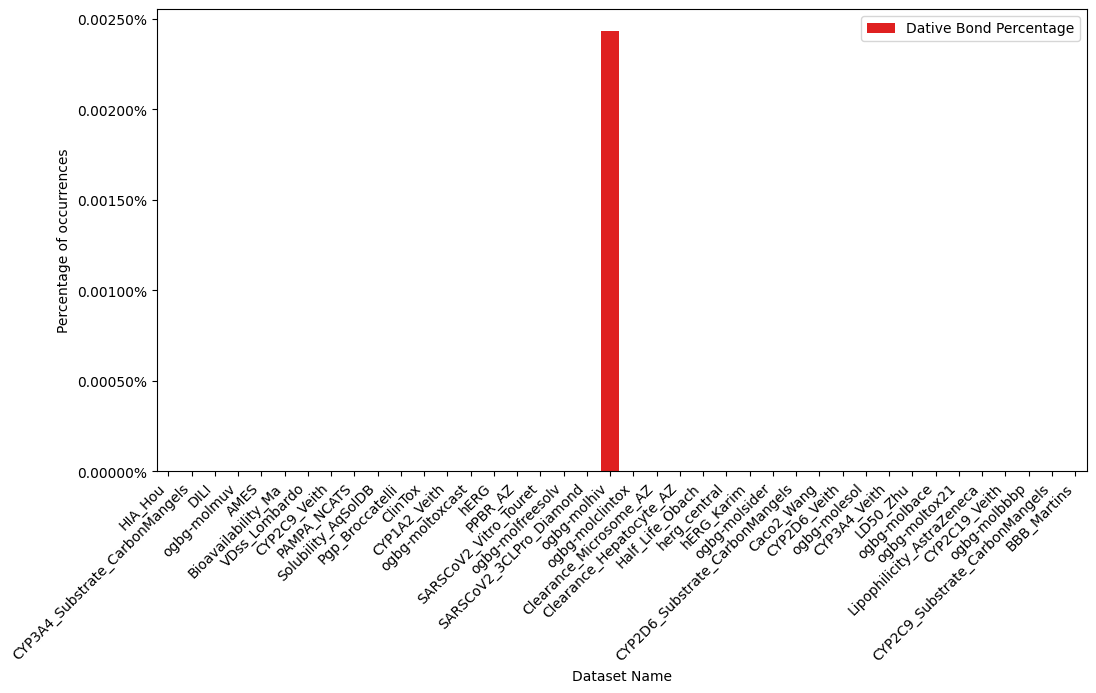

In [36]:
sns.barplot(
    data=meta_df,
    x='dataset_name',
    y='dative_perc',
    color='red',
    label='Dative Bond Percentage'
)

plt.ylabel('Percentage of occurrences')
plt.xlabel('Dataset Name')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gcf().set_size_inches(12, 6)

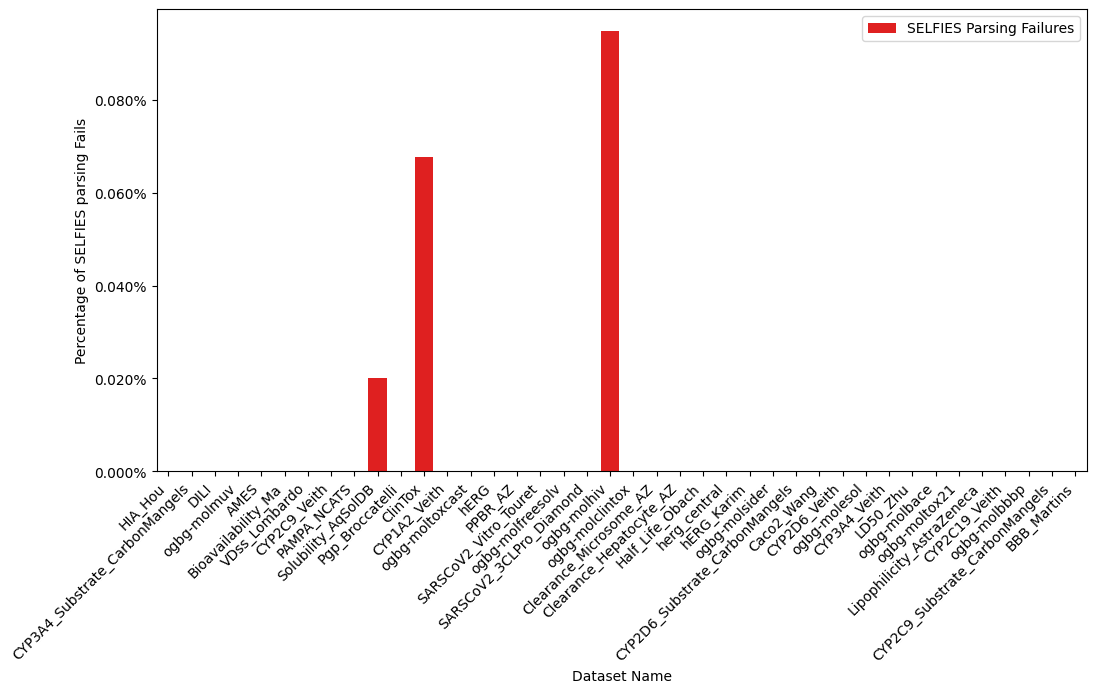

In [38]:
sns.barplot(
    data=meta_df,
    x='dataset_name',
    y='selfies_fails_perc',
    color='red',
    label='SELFIES Parsing Failures',
)

plt.ylabel('Percentage of SELFIES parsing Fails')
plt.xlabel('Dataset Name')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gcf().set_size_inches(12, 6)